In [1]:
import pandas as pd
import numpy as np
import re
import itertools
import torch
import ast
import matplotlib.pyplot as plt
from collections import defaultdict
from datetime import datetime
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader,TensorDataset



In [2]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print("Using device:", device)


Using device: cuda


In [3]:

# Define the correct file path (adjust if needed)
file_path_final = "./resale_flat_prices_final.xlsx"

# Load the Excel file
df_final = pd.read_excel(file_path_final)

# Drop missing values
df_final.dropna(inplace=True)

# Display first few rows
# df_final.head()

In [4]:
# One-hot encode town, flat_type, storey_category, flat_model and hdb_classification
town_ohe = pd.get_dummies(df_final['town']).values.astype(int).tolist()
flat_type_ohe = pd.get_dummies(df_final['flat_type']).values.astype(int).tolist()
storey_category_ohe = pd.get_dummies(df_final['storey_category']).values.astype(int).tolist()
flat_model_ohe = pd.get_dummies(df_final['flat_model']).values.astype(int).tolist()
hdb_classification_ohe = pd.get_dummies(df_final['hdb_classification']).values.astype(int).tolist()

df_final['town_one_hot'] = town_ohe
df_final['flat_type_one_hot'] = flat_type_ohe
df_final['storey_category_one_hot'] = storey_category_ohe
df_final['flat_model_one_hot'] = flat_model_ohe
df_final['hdb_classification_one_hot'] = hdb_classification_ohe

# Encode street_names as indices
street_name_to_idx = {name: idx for idx, name in enumerate(df_final['street_name'].unique())}
df_final['street_name_idx'] = df_final['street_name'].map(street_name_to_idx)

# Create embedding layer and apply to indices
num_street_names = len(street_name_to_idx)
embedding_dim = 16
embedding_layer = nn.Embedding(num_street_names, embedding_dim)

# Convert to tensor and pass through embedding layer
street_indices_tensor = torch.tensor(df_final['street_name_idx'].tolist(), dtype=torch.long)
street_embeddings = embedding_layer(street_indices_tensor)

# Convert embedding vectors to list and store in DataFrame
df_final['street_name_embed'] = street_embeddings.detach().numpy().tolist()

# df_final = df_final.drop(columns=['town', 'flat_type', 'storey_category', 'flat_model', 'street_name', 'street_name_idx', 'hdb_classification'])
df_final = df_final.drop(columns=['street_name_idx'])
output_file_path4 = "./resale_flat_prices_one_hot_vector_and_embed.xlsx"
df_final.to_excel(output_file_path4, index=False)

## Checking For Unique rows in dataset
"./resale_flat_prices_one_hot_vector_and_embed.xlsx"

In [5]:
# Flatten each row to a hashable tuple (handle list columns properly)
def row_to_tuple(row):
    flattened = []
    for val in row:
        if isinstance(val, list):
            flattened.extend(val)
        else:
            flattened.append(val)
    return tuple(flattened)

# Apply to each row
df_final['row_tuple'] = df_final.apply(row_to_tuple, axis=1)



'''
Example of row -> row_tuple transformation
row = {
     'month': '2017-01-01',
     'flat_type': '2 ROOM',
     'storey_category': 'Low',
     'floor_area_category': 40,
     'lease_commence_date': 1979.0,
     'remaining_lease': 61.33,
     'resale_price': 232000.0,
     'town_one_hot': [1, 0, 0, 0, 0],
     'flat_model_one_hot': [0, 0, 1],
     'hdb_classification_one_hot': [1, 0],
     'street_name_embed': [1.25, -0.25, 0.63]
 }

row_tuple=
 (
    '2017-01-01', '2 ROOM', 'Low', 40, 1979.0, 61.33, 232000.0,
     1, 0, 0, 0, 0,                     # town_one_hot
     0, 0, 1,                           # flat_model_one_hot
     1, 0,                              # hdb_classification_one_hot
     1.25, -0.25, 0.63                  # street_name_embed
 )

'''

# Count total and unique rows
total_rows = len(df_final)
unique_rows = df_final['row_tuple'].nunique()

print("Total rows:", total_rows)
print("Unique rows:", unique_rows)



Total rows: 391152
Unique rows: 391152


## Generate Static Vector

Static vectors are made from 
- 'town_one_hot', 
- 'flat_type',
- 'street_name_embed',
- 'storey_category', 
- 'floor_area_category', 
- 'flat_model_one_hot', 
- 'lease_commence_date',
- 'hdb_classification_one_hot' 

Row entries in this 'static vector' column can be thought of as a HDB flat profile

In [6]:
# Check data type for each static feature
static_features = [
    'town_one_hot', # list
    'flat_type_one_hot', #str
    'street_name_embed', # list
    'storey_category_one_hot', #str
    'floor_area_category', #numpy.int64
    'flat_model_one_hot', #list
    'lease_commence_date',#numpy.float64
    'hdb_classification_one_hot' #list
]
for feature in static_features:
  x=type(df_final.loc[0, feature])
  print(feature,x)


town_one_hot <class 'list'>
flat_type_one_hot <class 'list'>
street_name_embed <class 'list'>
storey_category_one_hot <class 'list'>
floor_area_category <class 'numpy.int64'>
flat_model_one_hot <class 'list'>
lease_commence_date <class 'numpy.float64'>
hdb_classification_one_hot <class 'list'>


In [7]:
counter =0 
for feature in static_features:
    sample = df_final.loc[0, feature]
    
    if isinstance(sample, list):
        length = len(sample)
        counter += length
    else:
        length = 1  # scalar (int, float, one-hot already mapped)
        counter += length
    
    print(f"{feature}: {length} dimensions")
print("Total dimensions for static features:", counter)

town_one_hot: 26 dimensions
flat_type_one_hot: 7 dimensions
street_name_embed: 16 dimensions
storey_category_one_hot: 2 dimensions
floor_area_category: 1 dimensions
flat_model_one_hot: 21 dimensions
lease_commence_date: 1 dimensions
hdb_classification_one_hot: 2 dimensions
Total dimensions for static features: 76


In [8]:
# Function to create static vector
def flatten_static_features(row):
    return torch.tensor(
        row['town_one_hot'] +
        row['flat_model_one_hot'] +
        row['hdb_classification_one_hot'] +
        row['street_name_embed'] +
        row['flat_type_one_hot'] +
        row['storey_category_one_hot']+
        [
            row['lease_commence_date'],
            row['floor_area_category'],
        ],
        dtype=torch.float32
    )

# Apply flatten_static_features function to every row in df_final
df_final['static_vector'] = df_final.apply(flatten_static_features, axis=1)

input_dim = len(df_final.loc[0, 'static_vector'])
print("Feedforward input dim:", input_dim)

# Sanity check: We now have column - static_vector - where every row is a 76 dimension tensor
df_final['static_vector']


Feedforward input dim: 76


0         [tensor(1.), tensor(0.), tensor(0.), tensor(0....
1         [tensor(0.), tensor(0.), tensor(0.), tensor(0....
2         [tensor(0.), tensor(0.), tensor(0.), tensor(0....
3         [tensor(0.), tensor(0.), tensor(0.), tensor(0....
4         [tensor(0.), tensor(0.), tensor(0.), tensor(0....
                                ...                        
391147    [tensor(0.), tensor(0.), tensor(0.), tensor(0....
391148    [tensor(0.), tensor(0.), tensor(0.), tensor(0....
391149    [tensor(0.), tensor(1.), tensor(0.), tensor(0....
391150    [tensor(0.), tensor(0.), tensor(0.), tensor(0....
391151    [tensor(0.), tensor(0.), tensor(0.), tensor(0....
Name: static_vector, Length: 391152, dtype: object

# Checking for unique static vectors 

Problem - Collapsing too many rows into a single static vector could result in static vectors with a short sequence length. Ideally, we'd want a sequence length of at least 12 months

Number of unique static vectors: 11897


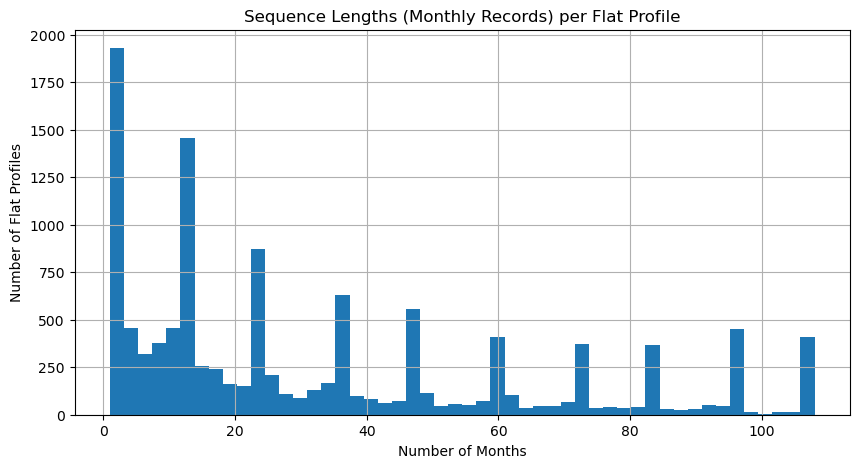

In [9]:
# Convert tensor to tuple for hashing purposes
df_final['static_tuple'] = df_final['static_vector'].apply(lambda x: tuple(x.tolist()))
# Count unique static vectors
num_unique_static_vectors = df_final['static_tuple'].nunique()
print("Number of unique static vectors:", num_unique_static_vectors)

# Get sequence lengths (i.e., number of rows per unique static vector)
profile_sequence_lengths = df_final['static_tuple'].value_counts()

# Plot the histogram of sequence lengths
plt.figure(figsize=(10, 5))
profile_sequence_lengths.hist(bins=50)
plt.title("Sequence Lengths (Monthly Records) per Flat Profile")
plt.xlabel("Number of Months")
plt.ylabel("Number of Flat Profiles")
plt.grid(True)
plt.show()


In [10]:
num_profiles_gt_12 = (profile_sequence_lengths > 12).sum()
num_profiles_lt_12 = (profile_sequence_lengths < 12).sum()
avg_length = profile_sequence_lengths[profile_sequence_lengths > 12].mean()
num_unique_static_vectors = df_final['static_tuple'].nunique()

print("Number of unique static profiles", num_unique_static_vectors)
print("Number of static profiles with > 12 months of data:", num_profiles_gt_12)
print("Average sequence length (for profiles >12 months):", avg_length)
print("Number of static profiles with < 12 months of data:", num_profiles_lt_12)
print("Total Number of Rows in dataset",len(df_final))


Number of unique static profiles 11897
Number of static profiles with > 12 months of data: 7110
Average sequence length (for profiles >12 months): 50.75977496483826
Number of static profiles with < 12 months of data: 3537
Total Number of Rows in dataset 391152


## Clean up 
Filtering out unique static vectors with <12 months of data

In [11]:
valid_profiles = profile_sequence_lengths[profile_sequence_lengths > 12].index
df_filtered = df_final[df_final['static_tuple'].isin(valid_profiles)]
print("Filtered dataset size:", len(df_filtered))


Filtered dataset size: 360902


## Contigious Check 

Now that we have identified our static vectors with more than 12 months of data, there is still 1 more check we should do. The sequence must be contiguous, meaning that the sequence should not be disjointed 

In [12]:
# Dictionary to track if each profile has 12+ *consecutive* months
valid_continuous_profiles = []

# Convert to datetime if not already
df_filtered['month'] = pd.to_datetime(df_filtered['month'])

# Group by static profile
grouped = df_filtered.groupby('static_tuple')

for static_key, group in grouped:
    months = group['month'].sort_values().reset_index(drop=True)

    # Convert to month difference from first month
    deltas = months.diff().dropna().dt.days

    # Count longest streak of monthly continuity (≤31 days between months)
    streak = 1
    max_streak = 1
    for gap in deltas:
        if gap <= 31:  # Allow 1-month gaps
            streak += 1
            max_streak = max(max_streak, streak)
        else:
            streak = 1  # Reset streak if gap too large

    if max_streak >= 12:
        valid_continuous_profiles.append(static_key)



C:\Users\User\AppData\Local\Temp\ipykernel_34388\2618642495.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['month'] = pd.to_datetime(df_filtered['month'])


In [13]:
df_strict = df_filtered[df_filtered['static_tuple'].isin(valid_continuous_profiles)]
print("Strictly valid profiles with ≥12 *consecutive* months:", len(valid_continuous_profiles))
print("Remaining rows:", len(df_strict))

Strictly valid profiles with ≥12 *consecutive* months: 5632
Remaining rows: 321699


In [14]:
# Update df_final to only include valid continuous profiles
df_final = df_strict.copy()
df_final.reset_index(drop=True, inplace=True)
print("Dataset size:", len(df_final))

Dataset size: 321699


## Define Train - Test - Val split



In [15]:

''' 
    Split dataset by flat profile. So each group is a flat profile with multiple months of data.
    Then sort each group by month to process the data in true chronological order
    Split each group into train, val, and test sets
    - Train: Before COVID
    - Val: 0-2 year after COVID
    - Test: 2+ years after COVID
'''

# Ensure 'month' column is datetime
df_final['month'] = pd.to_datetime(df_final['month'])

# Define COVID cutoff points
covid_start = pd.to_datetime("2020-01-01")
val_cutoff = pd.to_datetime("2022-01-01")
test_cutoff = pd.to_datetime("2022-01-01")  # Not strictly needed, just for clarity

# Split globally across all static profiles
df_train = df_final[df_final['month'] < covid_start].reset_index(drop=True)
df_val = df_final[(df_final['month'] >= covid_start) & (df_final['month'] < val_cutoff)].reset_index(drop=True)
df_test = df_final[df_final['month'] >= test_cutoff].reset_index(drop=True)

# ✅ Final sanity check
print(f"Train size: {len(df_train)} (Pre-COVID)")
print(f"Validation size: {len(df_val)} (0–2 year post-COVID)")
print(f"Test size: {len(df_test)} (2+ years post-COVID)")


Train size: 106344 (Pre-COVID)
Validation size: 75850 (0–2 year post-COVID)
Test size: 139505 (2+ years post-COVID)


### Round 2: Filter out Non-Contiguous Static Variables

After we have split our dataset into train-val-test sets, we might run into another round of non-contiguous data. Hence, we must filter them out again

In [16]:
def get_valid_continuous_profiles(df, min_streak=12):
    df['month'] = pd.to_datetime(df['month'])
    grouped = df.groupby('static_tuple')
    valid_profiles = []

    for static_key, group in grouped:
        months = group['month'].sort_values().reset_index(drop=True)
        deltas = months.diff().dropna().dt.days

        streak = 1
        max_streak = 1
        for gap in deltas:
            if gap <= 31:  # ≤1 month gap
                streak += 1
                max_streak = max(max_streak, streak)
            else:
                streak = 1
        if max_streak >= min_streak:
            valid_profiles.append(static_key)

    return valid_profiles


### Filter out non-contiguous data again

In [17]:
# Filter train
train_valid_profiles = get_valid_continuous_profiles(df_train)
df_train = df_train[df_train['static_tuple'].isin(train_valid_profiles)].reset_index(drop=True)

# Filter val
val_valid_profiles = get_valid_continuous_profiles(df_val)
df_val = df_val[df_val['static_tuple'].isin(val_valid_profiles)].reset_index(drop=True)

# Filter test
test_valid_profiles = get_valid_continuous_profiles(df_test)
df_test = df_test[df_test['static_tuple'].isin(test_valid_profiles)].reset_index(drop=True)

print("Filtered train size:", len(df_train))
print("Filtered val size:", len(df_val))
print("Filtered test size:", len(df_test))

Filtered train size: 96662
Filtered val size: 66164
Filtered test size: 133371


## Create Feedforward layer using static vectors

In [18]:

# Define the feedforward model
class StaticFFModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.ff = nn.Sequential(
            nn.Linear(input_dim, 128), # Hyperparameter
            nn.ReLU(),
            nn.Linear(128, output_dim),
            nn.ReLU()
        )

    def forward(self, x):
        return self.ff(x)

# Create instance
static_ff = StaticFFModel(input_dim=76, output_dim=76) # Note we should modify the output dimension to fit the hidden layer of the LSTM model. 

# Move model to MPS (or CUDA/CPU depending on your setup)
static_ff = static_ff.to(device)

#processing df_train
static_tensor_batch = torch.stack(df_train['static_vector'].tolist()).to(device)  
feedforward_output_train = static_ff(static_tensor_batch)
df_train['static_embedding'] = feedforward_output_train.detach().cpu().tolist()

#processing df_val
static_tensor_batch = torch.stack(df_val['static_vector'].tolist()).to(device)
feedforward_output_val = static_ff(static_tensor_batch)
df_val['static_embedding'] = feedforward_output_val.detach().cpu().tolist()

#processing df_test
static_tensor_batch = torch.stack(df_test['static_vector'].tolist()).to(device)
feedforward_output_test = static_ff(static_tensor_batch)
df_test['static_embedding'] = feedforward_output_test.detach().cpu().tolist()

print ("Train set with static embedding shape:", df_train['static_embedding'].apply(lambda x: len(x)).unique())
print ("Val set with static embedding shape:", df_val['static_embedding'].apply(lambda x: len(x)).unique())
print ("Test set with static embedding shape:", df_test['static_embedding'].apply(lambda x: len(x)).unique())



Train set with static embedding shape: [76]
Val set with static embedding shape: [76]
Test set with static embedding shape: [76]


# Normalize Non-static features

Price and Remaining Lease

In [19]:
# Only from training set
resale_mean = df_train['resale_price'].mean()
resale_std = df_train['resale_price'].std()

lease_mean = df_train['remaining_lease'].mean()
lease_std = df_train['remaining_lease'].std()


In [20]:
# Normalize resale_price and remaining_lease
for df in [df_train, df_val, df_test]:
    df['resale_price_normalized'] = (df['resale_price'] - resale_mean) / resale_std
    df['remaining_lease_normalized'] = (df['remaining_lease'] - lease_mean) / lease_std


# Sliding Window

In [21]:
def generate_sequences(df, window_size=12):
    x_combined_list = []
    y_list = []

    grouped = df.groupby("static_tuple")

    for _, group in grouped:
        group = group.sort_values("month").reset_index(drop=True)

        if len(group) < window_size + 1:
            continue  # not enough data to create a window
        

        for i in range(len(group) - window_size):
            # Select 12 rows of data at row i, with 2 columns: resale_price and remaining_lease
            # x_window.shape = [12, 2]
            x_window = group.loc[i:i+window_size-1, ["resale_price_normalized", "remaining_lease_normalized"]].values
            
        
            # Obtain static embedding at time t+1
            # repeat for 12 time steps
            x_static = group.loc[i+window_size, "static_embedding"]
            x_static_repeated = np.tile(x_static, (window_size, 1))  
            
            # Concatenate dynamic and static features 
            x_combined = np.concatenate([x_window, x_static_repeated], axis=1)

            # Target: resale_price at time t+1
            y = group.loc[i+window_size, "resale_price_normalized"]

            x_combined_list.append(x_combined) # Store input 
            y_list.append(y) #Store output

    # Convert to tensors
    X_tensor = torch.tensor(np.array(x_combined_list), dtype=torch.float32)  # [N, 12, 76]
    y_tensor = torch.tensor(np.array(y_list), dtype=torch.float32)           # [N]

    return X_tensor, y_tensor


In [22]:
X_train, y_train = generate_sequences(df_train)
X_val, y_val = generate_sequences(df_val)
X_test, y_test = generate_sequences(df_test)

print("Train shape:", X_train.shape, y_train.shape)
print("Val shape:", X_val.shape, y_val.shape)
print("Test shape:", X_test.shape, y_test.shape)


Train shape: torch.Size([49862, 12, 78]) torch.Size([49862])
Val shape: torch.Size([23984, 12, 78]) torch.Size([23984])
Test shape: torch.Size([76923, 12, 78]) torch.Size([76923])


In [23]:
def get_tensor_loader(X_tensor, y_tensor, batch_size=32, shuffle=True):
    dataset = TensorDataset(X_tensor, y_tensor)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

In [24]:
train_loader = get_tensor_loader(X_train, y_train, batch_size=32, shuffle=True)
val_loader = get_tensor_loader(X_val, y_val, batch_size=32, shuffle=False)
test_loader = get_tensor_loader(X_test, y_test, batch_size=32, shuffle=False)


## Save train, val and test dataframes

In [25]:
# Save train, val, and test dataframes
# df_train.to_csv("train_data.csv", index=False)
# df_val.to_csv("val_data.csv", index=False)
# df_test.to_csv("test_data.csv", index=False)

# LSTM

In [26]:
class LSTMEncoder(nn.Module):
    def __init__(self, non_static_dim, static_embedding_dim, hidden_dim, num_layers=1):
        super().__init__()
        input_dim = non_static_dim + static_embedding_dim
        self.lstm = nn.LSTM(
            input_size=input_dim, # 2 +76 (dynamic + static) = 78 
            hidden_size=hidden_dim, # Hyperparameter
            num_layers=num_layers, # Hyperparameter
            batch_first=True # input tensor (x) shape is set to [batch_size, sequence_length, input_dim]
        )

    def forward(self, x):
        # x shape: [batch_size, sequence_length, input_dim]
        # out is the hidden state for all time steps
        # hidden = (hn, cn), for simplicity
        # hn is the hidden state for the last time step 
        # cn is the cell state (long term history for the last time step
        out, hidden = self.lstm(x)
        return hidden  # Return full hidden & cell states
    


In [27]:
class LSTMDecoder(nn.Module):
    def __init__(self, hidden_dim, static_embedding_dim, output_dim=1):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.input_dim = output_dim + static_embedding_dim  # 1 + 76
        self.lstm = nn.LSTM(input_size=self.input_dim, hidden_size=hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, target_len, static_embed, hidden, teacher_forcing_inputs=None, teacher_forcing_ratio=0.5):
        """
        Inputs:
        - target_len: length of the target sequence:, how many resale prices to predict ? 
        - static_embed: [B, 64] - static embedding repeated for each time step 
        - hidden = (hn, cn): states from encoder
        - teacher_forcing_inputs: [B, target_len] optional ground truth inputs values 
        - teacher_forcing_ratio: how often to use ground truth vs predicted values 
        Returns:
        - outputs: [B, target_len]
        """
        batch_size = static_embed.size(0) # Batch size 
        output_dim = self.fc.out_features # 1 
        outputs = []

        # First input: zero resale price
        input_step = torch.zeros(batch_size, 1, output_dim).to(static_embed.device)

        # Run the decoder target_len times 
        # If we want a prediction 5 years ahead, target_len = 60
        for t in range(target_len):
            # Concatenate static embedding to every input
            static_t = static_embed.unsqueeze(1)  # [B, 1, 76]
            lstm_input = torch.cat([input_step, static_t], dim=2)  # [B, 1, 1+76]

            out, hidden = self.lstm(lstm_input, hidden)  # out: [B, 1, H]
            output = self.fc(out)  # [B, 1, 1]
            outputs.append(output.squeeze(1))  # [B, 1] → squeeze time dim

            # Decide whether to use teacher forcing
            # When training, we can use teacher forcing to improve convergence
            # When doing inference into the future, we use the predicted value
            if teacher_forcing_inputs is not None and torch.rand(1).item() < teacher_forcing_ratio:
                input_step = teacher_forcing_inputs[:, t].unsqueeze(1).unsqueeze(-1)  # [B, 1, 1]
            else:
                input_step = output  # Autoregressive prediction 

        return torch.cat(outputs, dim=1)  # [B, target_len]


In [28]:
class Seq2SeqModel(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x, static_embed, target_len=1, teacher_forcing_inputs=None, teacher_forcing_ratio=0.5):

        hidden = self.encoder(x) # Obtain hidden and cell states from encoder
        return self.decoder(
            target_len=target_len,
            static_embed=static_embed,
            hidden=hidden,
            teacher_forcing_inputs=teacher_forcing_inputs,
            teacher_forcing_ratio=teacher_forcing_ratio
        )


def train_epoch(model, dataloader, optimizer, criterion, device, target_len=1, teacher_forcing=True):
    model.train()
    total_loss = 0

    for x_batch, y_batch in dataloader:
        x_batch = x_batch.to(device)             
        y_batch = y_batch.to(device)          

        static_embed = x_batch[:, 0, -76:]        # extract static embedding (same across all time steps)

        # If teacher forcing, use the ground truth values for the next time step 
        # Else use the predicted values
        teacher_inputs = y_batch.unsqueeze(1) if teacher_forcing else None  

        optimizer.zero_grad()
        outputs = model(
            x_batch,
            static_embed,
            target_len=target_len,
            teacher_forcing_inputs=teacher_inputs,
            teacher_forcing_ratio=0.5 if teacher_forcing else 0.0 # Hyperparameter
        )

        # If multi-step: criterion on all time steps; if single-step: squeeze
        if target_len == 1:
            outputs = outputs.squeeze(1)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)




In [29]:
def validate_epoch(model, dataloader, criterion, device, resale_mean, resale_std, target_len=1):
    model.eval()
    total_loss = 0
    preds = []
    trues = []

    with torch.no_grad():
        for x_batch, y_batch in dataloader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            static_embed = x_batch[:, 0, -76:]

            outputs = model(
                x_batch,
                static_embed,
                target_len=target_len,
                teacher_forcing_inputs=None,
                teacher_forcing_ratio=0.0
            )

            if target_len == 1:
                outputs = outputs.squeeze(1)

            loss = criterion(outputs, y_batch)
            total_loss += loss.item()

            preds.append(outputs.cpu())
            trues.append(y_batch.cpu())

    preds = torch.cat(preds).numpy()
    trues = torch.cat(trues).numpy()

    # Denormalize
    preds_denorm = preds * resale_std + resale_mean
    trues_denorm = trues * resale_std + resale_mean

    # Compute metrics
    mae = np.mean(np.abs(trues_denorm - preds_denorm))
    ss_res = np.sum((trues_denorm - preds_denorm) ** 2)
    ss_tot = np.sum((trues_denorm - np.mean(trues_denorm)) ** 2)
    r2 = 1 - ss_res / ss_tot

    return total_loss / len(dataloader), mae, r2, preds_denorm, trues_denorm


In [30]:
def plot_predictions(true_values, predicted_values, title="Validation Predictions"):
    plt.figure(figsize=(6, 6))
    plt.scatter(true_values, predicted_values, alpha=0.3)
    plt.plot([true_values.min(), true_values.max()],
             [true_values.min(), true_values.max()], 'r--')
    plt.xlabel("True Resale Price")
    plt.ylabel("Predicted Resale Price")
    plt.title(title)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


Epoch 1 | Train Loss: 0.2420 | Val Loss: 0.0726 | MAE: 36147.14 | R²: 0.93
Epoch 2 | Train Loss: 0.0364 | Val Loss: 0.0373 | MAE: 24356.08 | R²: 0.97
Epoch 3 | Train Loss: 0.0350 | Val Loss: 0.0355 | MAE: 22475.16 | R²: 0.97
Epoch 4 | Train Loss: 0.0326 | Val Loss: 0.0580 | MAE: 33421.25 | R²: 0.95
Epoch 5 | Train Loss: 0.0310 | Val Loss: 0.0884 | MAE: 42229.13 | R²: 0.92
Epoch 6 | Train Loss: 0.0305 | Val Loss: 0.0524 | MAE: 30873.66 | R²: 0.95
Epoch 7 | Train Loss: 0.0297 | Val Loss: 0.1922 | MAE: 71526.26 | R²: 0.82
Epoch 8 | Train Loss: 0.0319 | Val Loss: 0.0369 | MAE: 22599.91 | R²: 0.97
Epoch 9 | Train Loss: 0.0332 | Val Loss: 0.0365 | MAE: 21949.16 | R²: 0.97
Epoch 10 | Train Loss: 0.0291 | Val Loss: 0.0343 | MAE: 21553.66 | R²: 0.97


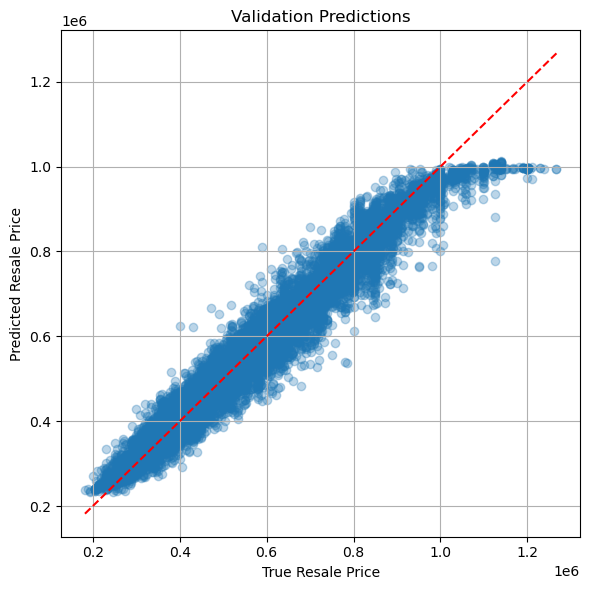

In [31]:
non_static_dim = 2         # resale_price_normalized + remaining_lease_normalized
static_embedding_dim = 76  # output of your StaticFFModel
hidden_dim = 76            # tunable

encoder = LSTMEncoder(
    non_static_dim=non_static_dim,
    static_embedding_dim=static_embedding_dim,
    hidden_dim=hidden_dim,
    num_layers=1
).to(device)

decoder = LSTMDecoder(
    hidden_dim=hidden_dim,
    static_embedding_dim=static_embedding_dim,
    output_dim=1
).to(device)

model = Seq2SeqModel(encoder, decoder).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

for epoch in range(10):
    train_loss = train_epoch(model, train_loader, optimizer, criterion, device, target_len=1)

    val_loss, val_mae, val_r2, val_preds, val_trues = validate_epoch(
        model, val_loader, criterion, device,
        resale_mean=resale_mean, resale_std=resale_std,
        target_len=1
    )

    print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | MAE: {val_mae:.2f} | R²: {val_r2:.2f}")
plot_predictions(val_trues, val_preds)


In [32]:
# Add normalization columns
df_final["resale_price_normalized"] = (df_final["resale_price"] - resale_mean) / resale_std
df_final["remaining_lease_normalized"] = df_final["remaining_lease"] / 99.0  # assuming max 99-year lease
def build_static_embedding(row):
    return np.concatenate([
        np.array(row['town_one_hot']),
        np.array(row['flat_type_one_hot']),
        np.array(row['storey_category_one_hot']),
        np.array(row['flat_model_one_hot']),
        np.array(row['hdb_classification_one_hot']),
        np.array(row['street_name_embed']),
        np.array([row['lease_commence_date'] / 2025.0]),         # normalize year
        np.array([row['floor_area_category'] / 200.0])           # normalize area
    ])

df_final["static_embedding"] = df_final.apply(build_static_embedding, axis=1)

In [33]:
def recommend_profitable_flats(town, budget, purchase_year, forecast_years, df, model, device, resale_mean, resale_std):
    model.eval()
    purchase_cutoff = pd.to_datetime(f"{purchase_year}-12-31")
    df_filtered = df[(df['town'] == town) & (df['month'] <= purchase_cutoff) & (df['resale_price'] <= budget)]
    df_filtered.columns.tolist()
    results = []
    with torch.no_grad():
        for key, group in df_filtered.groupby("static_tuple"):
            group = group.sort_values("month").reset_index(drop=True)

            if len(group) < 12:
                continue  # skip if not enough months for sliding window

            # Simulate 12-month time window from most recent data before purchase_year
            x_window = group.iloc[-12:][["resale_price_normalized", "remaining_lease_normalized"]].values  # [12, 2]
            static_embed = group.iloc[-1]["static_embedding"]  # 
            x_static_repeated = np.tile(static_embed, (12, 1))  # 
            x_combined = np.concatenate([x_window, x_static_repeated], axis=1)  # 

            x_tensor = torch.tensor(x_combined, dtype=torch.float32).unsqueeze(0).to(device)  # [1, 12, 66]
            static_tensor = torch.tensor(static_embed, dtype=torch.float32).unsqueeze(0).to(device)  # [1, 64]

            # Forecast resale prices
            forecast_len = max(forecast_years)
            forecast = model(x_tensor, static_tensor, target_len=forecast_len, teacher_forcing_inputs=None, teacher_forcing_ratio=0.0)
            forecast = forecast.squeeze(0).cpu().numpy()  # [forecast_len]

            # Denormalize predictions
            forecast_denorm = forecast * resale_std + resale_mean

            for year in forecast_years:
                future_price = forecast_denorm[year - 1]
                buy_price = group.iloc[-1]["resale_price"]
                profit = future_price - buy_price
                results.append({
                    "street_name": group.iloc[-1]["street_name"] if "street_name" in group.columns else str(key),
                    "flat_type": group.iloc[-1]["flat_type"] if "flat_type" in group.columns else "Unknown",
                    "purchase_price": buy_price,
                    "year": purchase_year + year,
                    "predicted_price": future_price,
                    "estimated_profit": profit
                })

    # Sort by highest average profit per street
    result_df = pd.DataFrame(results)
    print(result_df.empty)
    print(result_df.columns)
    top_streets = result_df.groupby("street_name")["estimated_profit"].mean().sort_values(ascending=False).head(10)

    
    print("\n🏆 Top 10 Profitable Streets:")
    print(top_streets)
 
    return result_df, top_streets


In [34]:
print("Available columns:", df.columns.tolist())

Available columns: ['month', 'town', 'flat_type', 'street_name', 'storey_category', 'floor_area_category', 'flat_model', 'lease_commence_date', 'remaining_lease', 'resale_price', 'hdb_classification', 'town_one_hot', 'flat_type_one_hot', 'storey_category_one_hot', 'flat_model_one_hot', 'hdb_classification_one_hot', 'street_name_embed', 'row_tuple', 'static_vector', 'static_tuple', 'static_embedding', 'resale_price_normalized', 'remaining_lease_normalized']


In [35]:
results_df_lstm, top_streets_lstm = recommend_profitable_flats(
    town="TAMPINES",
    budget=500000,
    purchase_year=2017,
    forecast_years=[5, 6, 7],
    df=df_final,
    model=model,
    device=device,
    resale_mean=resale_mean,
    resale_std=resale_std
)


False
Index(['street_name', 'flat_type', 'purchase_price', 'year', 'predicted_price',
       'estimated_profit'],
      dtype='object')

🏆 Top 10 Profitable Streets:
street_name
TAMPINES ST 41     302259.296871
SIMEI RD           235931.585065
TAMPINES ST 24     227510.054466
TAMPINES ST 84     222835.288190
TAMPINES ST 22     185688.205291
TAMPINES ST 23     168113.435326
TAMPINES ST 42     165688.087778
TAMPINES ST 82     156508.245872
TAMPINES ST 12     154996.608286
TAMPINES CTRL 1    135658.232201
Name: estimated_profit, dtype: float64


# GRU

In [36]:
class GRUEncoder(nn.Module):
    def __init__(self, non_static_dim, static_embedding_dim, hidden_dim, num_layers=1):
        super().__init__()
        input_dim = non_static_dim + static_embedding_dim
        self.gru = nn.GRU(
            input_size=input_dim, # 2 +76 (dynamic + static) = 78 
            hidden_size=hidden_dim, # Hyperparameter
            num_layers=num_layers, # Hyperparameter
            batch_first=True # input tensor (x) shape is set to [batch_size, sequence_length, input_dim]
        )

    def forward(self, x):
        # x shape: [batch_size, sequence_length, input_dim]
        # out is the hidden state for all time steps
        # hidden = hidden state for the last time step
        out, hidden = self.gru(x)
        return hidden  # Return full hidden & cell states

In [37]:
class GRUDecoder(nn.Module):
    def __init__(self, hidden_dim, static_embedding_dim, output_dim=1):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.input_dim = output_dim + static_embedding_dim  # 1 + 76
        self.gru = nn.GRU(input_size=self.input_dim, hidden_size=hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, target_len, static_embed, hidden, teacher_forcing_inputs=None, teacher_forcing_ratio=0.5):
        """
        Inputs:
        - target_len: length of the target sequence:, how many resale prices to predict ? 
        - static_embed: [B, 64] - static embedding repeated for each time step 
        - hidden: state from encoder
        - teacher_forcing_inputs: [B, target_len] optional ground truth inputs values 
        - teacher_forcing_ratio: how often to use ground truth vs predicted values 
        Returns:
        - outputs: [B, target_len]
        """
        batch_size = static_embed.size(0) # Batch size 
        output_dim = self.fc.out_features # 1 
        outputs = []

        # First input: zero resale price
        input_step = torch.zeros(batch_size, 1, output_dim).to(static_embed.device)

        # Run the decoder target_len times 
        # If we want a prediction 5 years ahead, target_len = 60
        for t in range(target_len):
            # Concatenate static embedding to every input
            static_t = static_embed.unsqueeze(1)  # [B, 1, 76]
            lstm_input = torch.cat([input_step, static_t], dim=2)  # [B, 1, 1+76]

            out, hidden = self.gru(lstm_input, hidden)  # out: [B, 1, H]
            output = self.fc(out)  # [B, 1, 1]
            outputs.append(output.squeeze(1))  # [B, 1] → squeeze time dim

            # Decide whether to use teacher forcing
            # When training, we can use teacher forcing to improve convergence
            # When doing inference into the future, we use the predicted value
            if teacher_forcing_inputs is not None and torch.rand(1).item() < teacher_forcing_ratio:
                input_step = teacher_forcing_inputs[:, t].unsqueeze(1).unsqueeze(-1)  # [B, 1, 1]
            else:
                input_step = output  # Autoregressive prediction 

        return torch.cat(outputs, dim=1)  # [B, target_len]

Epoch 1 | Train Loss: 0.4819 | Val Loss: 0.1662 | MAE: 48011.85 | R²: 0.85
Epoch 2 | Train Loss: 0.0656 | Val Loss: 0.4770 | MAE: 114157.11 | R²: 0.56
Epoch 3 | Train Loss: 0.0490 | Val Loss: 0.0741 | MAE: 35853.21 | R²: 0.93
Epoch 4 | Train Loss: 0.0437 | Val Loss: 0.1483 | MAE: 57160.01 | R²: 0.86
Epoch 5 | Train Loss: 0.0416 | Val Loss: 0.0669 | MAE: 35133.25 | R²: 0.94
Epoch 6 | Train Loss: 0.0421 | Val Loss: 0.0486 | MAE: 27452.60 | R²: 0.96
Epoch 7 | Train Loss: 0.0409 | Val Loss: 0.1110 | MAE: 46761.26 | R²: 0.90
Epoch 8 | Train Loss: 0.0402 | Val Loss: 0.0512 | MAE: 27995.96 | R²: 0.95
Epoch 9 | Train Loss: 0.0397 | Val Loss: 0.1572 | MAE: 61266.24 | R²: 0.86
Epoch 10 | Train Loss: 0.0365 | Val Loss: 0.0934 | MAE: 43085.49 | R²: 0.91


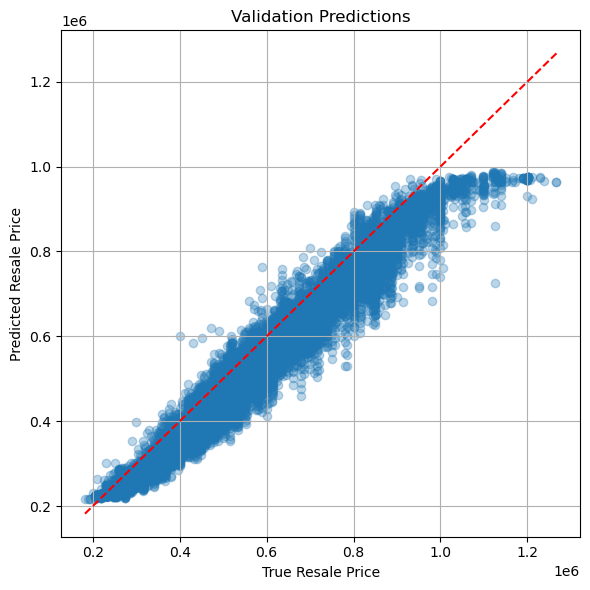

In [38]:
non_static_dim = 2         # resale_price_normalized + remaining_lease_normalized
static_embedding_dim = 76  # output of your StaticFFModel
hidden_dim = 76            # tunable

encoder = GRUEncoder(
    non_static_dim=non_static_dim,
    static_embedding_dim=static_embedding_dim,
    hidden_dim=hidden_dim,
    num_layers=1
).to(device)

decoder = GRUDecoder(
    hidden_dim=hidden_dim,
    static_embedding_dim=static_embedding_dim,
    output_dim=1
).to(device)

model = Seq2SeqModel(encoder, decoder).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

for epoch in range(10):
    train_loss = train_epoch(model, train_loader, optimizer, criterion, device, target_len=1)

    val_loss, val_mae, val_r2, val_preds, val_trues = validate_epoch(
        model, val_loader, criterion, device,
        resale_mean=resale_mean, resale_std=resale_std,
        target_len=1
    )

    print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | MAE: {val_mae:.2f} | R²: {val_r2:.2f}")
plot_predictions(val_trues, val_preds)


In [39]:
print("Available columns:", df.columns.tolist())

Available columns: ['month', 'town', 'flat_type', 'street_name', 'storey_category', 'floor_area_category', 'flat_model', 'lease_commence_date', 'remaining_lease', 'resale_price', 'hdb_classification', 'town_one_hot', 'flat_type_one_hot', 'storey_category_one_hot', 'flat_model_one_hot', 'hdb_classification_one_hot', 'street_name_embed', 'row_tuple', 'static_vector', 'static_tuple', 'static_embedding', 'resale_price_normalized', 'remaining_lease_normalized']


In [40]:
results_df_gru, top_streets_gru = recommend_profitable_flats(
    town="TAMPINES",
    budget=500000,
    purchase_year=2017,
    forecast_years=[5, 6, 7],
    df=df_final,
    model=model,
    device=device,
    resale_mean=resale_mean,
    resale_std=resale_std
)


False
Index(['street_name', 'flat_type', 'purchase_price', 'year', 'predicted_price',
       'estimated_profit'],
      dtype='object')

🏆 Top 10 Profitable Streets:
street_name
TAMPINES AVE 9    283136.010846
TAMPINES ST 71    228336.884544
TAMPINES ST 34    192586.427513
TAMPINES AVE 4    152059.413841
TAMPINES ST 12    135658.271873
TAMPINES ST 72    127712.270612
TAMPINES AVE 8    123545.104596
TAMPINES ST 24    118508.465273
TAMPINES ST 83     99560.957461
TAMPINES ST 82     37636.312604
Name: estimated_profit, dtype: float64


# GRU-to-LSTM

In [41]:
class GRUtoLSTM(nn.Module):
    def __init__(self, encoder: GRUEncoder, decoder: LSTMDecoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x, static_embed, target_len=1, teacher_forcing_inputs=None, teacher_forcing_ratio=0.5):

        hidden = self.encoder(x) # Obtain hidden and cell states from encoder
        return self.decoder(
            target_len=target_len,
            static_embed=static_embed,
            hidden=(hidden, hidden),
            teacher_forcing_inputs=teacher_forcing_inputs,
            teacher_forcing_ratio=teacher_forcing_ratio
        )

Epoch 1 | Train Loss: 0.3801 | Val Loss: 0.1557 | MAE: 52539.52 | R²: 0.86
Epoch 2 | Train Loss: 0.0719 | Val Loss: 0.0819 | MAE: 33459.90 | R²: 0.92
Epoch 3 | Train Loss: 0.0647 | Val Loss: 0.1072 | MAE: 42045.72 | R²: 0.90
Epoch 4 | Train Loss: 0.0615 | Val Loss: 0.0731 | MAE: 31916.14 | R²: 0.93
Epoch 5 | Train Loss: 0.0607 | Val Loss: 0.0775 | MAE: 33100.76 | R²: 0.93
Epoch 6 | Train Loss: 0.0601 | Val Loss: 0.1132 | MAE: 46411.53 | R²: 0.90
Epoch 7 | Train Loss: 0.0621 | Val Loss: 0.1135 | MAE: 46245.42 | R²: 0.90
Epoch 8 | Train Loss: 0.0621 | Val Loss: 0.0953 | MAE: 40388.51 | R²: 0.91
Epoch 9 | Train Loss: 0.0598 | Val Loss: 0.0899 | MAE: 37154.27 | R²: 0.92
Epoch 10 | Train Loss: 0.0620 | Val Loss: 0.1787 | MAE: 63357.70 | R²: 0.84


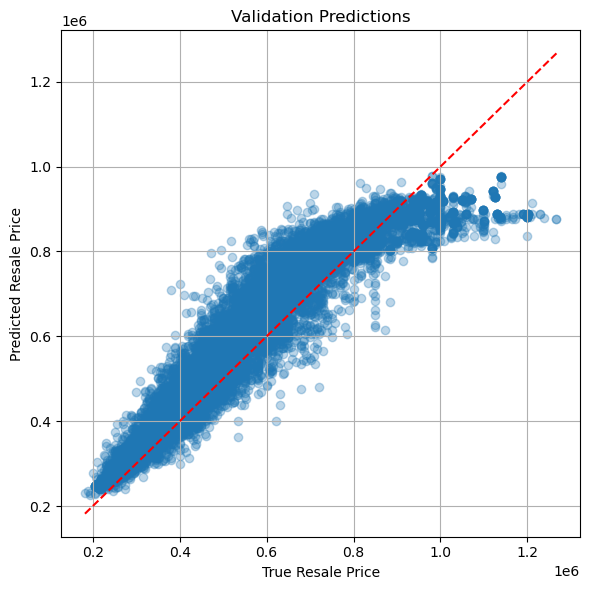

In [42]:
non_static_dim = 2         # resale_price_normalized + remaining_lease_normalized
static_embedding_dim = 76  # output of your StaticFFModel
hidden_dim = 76            # tunable

encoder = GRUEncoder(
    non_static_dim=non_static_dim,
    static_embedding_dim=static_embedding_dim,
    hidden_dim=hidden_dim,
    num_layers=1
).to(device)

decoder = LSTMDecoder(
    hidden_dim=hidden_dim,
    static_embedding_dim=static_embedding_dim,
    output_dim=1
).to(device)

model = GRUtoLSTM(encoder, decoder).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

for epoch in range(10):
    train_loss = train_epoch(model, train_loader, optimizer, criterion, device, target_len=1)

    val_loss, val_mae, val_r2, val_preds, val_trues = validate_epoch(
        model, val_loader, criterion, device,
        resale_mean=resale_mean, resale_std=resale_std,
        target_len=1
    )

    print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | MAE: {val_mae:.2f} | R²: {val_r2:.2f}")
plot_predictions(val_trues, val_preds)


In [43]:
print("Available columns:", df.columns.tolist())

Available columns: ['month', 'town', 'flat_type', 'street_name', 'storey_category', 'floor_area_category', 'flat_model', 'lease_commence_date', 'remaining_lease', 'resale_price', 'hdb_classification', 'town_one_hot', 'flat_type_one_hot', 'storey_category_one_hot', 'flat_model_one_hot', 'hdb_classification_one_hot', 'street_name_embed', 'row_tuple', 'static_vector', 'static_tuple', 'static_embedding', 'resale_price_normalized', 'remaining_lease_normalized']


In [44]:
results_df_gru2lstm, top_streets_gru2lstm = recommend_profitable_flats(
    town="TAMPINES",
    budget=500000,
    purchase_year=2017,
    forecast_years=[5, 6, 7],
    df=df_final,
    model=model,
    device=device,
    resale_mean=resale_mean,
    resale_std=resale_std
)


False
Index(['street_name', 'flat_type', 'purchase_price', 'year', 'predicted_price',
       'estimated_profit'],
      dtype='object')

🏆 Top 10 Profitable Streets:
street_name
TAMPINES AVE 4     176971.313581
TAMPINES ST 41     170204.192921
TAMPINES ST 24     109073.186628
TAMPINES ST 21      84997.373867
TAMPINES ST 42      77742.702253
TAMPINES AVE 8      75128.043398
TAMPINES ST 71      67816.445071
SIMEI RD            64349.292747
TAMPINES CTRL 1     51506.818464
TAMPINES ST 82      51296.100365
Name: estimated_profit, dtype: float64


# LSTM-to-GRU

In [45]:
class LSTMtoGRU(nn.Module):
    def __init__(self, encoder: GRUEncoder, decoder: LSTMDecoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x, static_embed, target_len=1, teacher_forcing_inputs=None, teacher_forcing_ratio=0.5):

        hidden = self.encoder(x) # Obtain hidden and cell states from encoder
        hidden = torch.cat(hidden, dim=-1)
        # print(hidden.shape)
        return self.decoder(
            target_len=target_len,
            static_embed=static_embed,
            hidden=hidden,
            teacher_forcing_inputs=teacher_forcing_inputs,
            teacher_forcing_ratio=teacher_forcing_ratio
        )

Epoch 1 | Train Loss: 0.1476 | Val Loss: 0.0367 | MAE: 24098.31 | R²: 0.97
Epoch 2 | Train Loss: 0.0323 | Val Loss: 0.0332 | MAE: 21572.42 | R²: 0.97
Epoch 3 | Train Loss: 0.0298 | Val Loss: 0.0685 | MAE: 37826.53 | R²: 0.94
Epoch 4 | Train Loss: 0.0269 | Val Loss: 0.0315 | MAE: 21477.49 | R²: 0.97
Epoch 5 | Train Loss: 0.0252 | Val Loss: 0.1026 | MAE: 46975.98 | R²: 0.91
Epoch 6 | Train Loss: 0.0256 | Val Loss: 0.0674 | MAE: 38016.65 | R²: 0.94
Epoch 7 | Train Loss: 0.0265 | Val Loss: 0.0390 | MAE: 25640.19 | R²: 0.96
Epoch 8 | Train Loss: 0.0263 | Val Loss: 0.0560 | MAE: 31630.46 | R²: 0.95
Epoch 9 | Train Loss: 0.0271 | Val Loss: 0.0340 | MAE: 22552.25 | R²: 0.97
Epoch 10 | Train Loss: 0.0256 | Val Loss: 0.0322 | MAE: 21033.59 | R²: 0.97


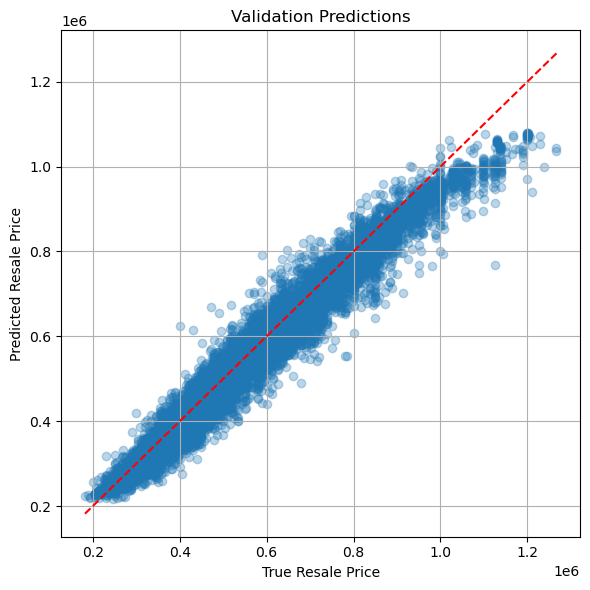

In [46]:
non_static_dim = 2         # resale_price_normalized + remaining_lease_normalized
static_embedding_dim = 76  # output of your StaticFFModel
hidden_dim = 76            # tunable

encoder = LSTMEncoder(
    non_static_dim=non_static_dim,
    static_embedding_dim=static_embedding_dim,
    hidden_dim=hidden_dim,
    num_layers=1
).to(device)

decoder = GRUDecoder(
    hidden_dim=hidden_dim*2,    # doubled due to hidden & cells state concatenation from LSTM
    static_embedding_dim=static_embedding_dim,
    output_dim=1
).to(device)

model = LSTMtoGRU(encoder, decoder).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

for epoch in range(10):
    train_loss = train_epoch(model, train_loader, optimizer, criterion, device, target_len=1)

    val_loss, val_mae, val_r2, val_preds, val_trues = validate_epoch(
        model, val_loader, criterion, device,
        resale_mean=resale_mean, resale_std=resale_std,
        target_len=1
    )

    print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | MAE: {val_mae:.2f} | R²: {val_r2:.2f}")
plot_predictions(val_trues, val_preds)


In [47]:
print("Available columns:", df.columns.tolist())

Available columns: ['month', 'town', 'flat_type', 'street_name', 'storey_category', 'floor_area_category', 'flat_model', 'lease_commence_date', 'remaining_lease', 'resale_price', 'hdb_classification', 'town_one_hot', 'flat_type_one_hot', 'storey_category_one_hot', 'flat_model_one_hot', 'hdb_classification_one_hot', 'street_name_embed', 'row_tuple', 'static_vector', 'static_tuple', 'static_embedding', 'resale_price_normalized', 'remaining_lease_normalized']


In [48]:
results_df_lstm2gru, top_streets_lstm2gru = recommend_profitable_flats(
    town="TAMPINES",
    budget=500000,
    purchase_year=2017,
    forecast_years=[5, 6, 7],
    df=df_final,
    model=model,
    device=device,
    resale_mean=resale_mean,
    resale_std=resale_std
)


False
Index(['street_name', 'flat_type', 'purchase_price', 'year', 'predicted_price',
       'estimated_profit'],
      dtype='object')

🏆 Top 10 Profitable Streets:
street_name
TAMPINES ST 24    251227.579857
TAMPINES AVE 8    189113.605247
TAMPINES ST 22    167234.323780
TAMPINES ST 83    155738.512148
TAMPINES AVE 4    139203.514722
TAMPINES ST 42    125207.071285
TAMPINES ST 21    121816.242137
TAMPINES ST 71    111052.741315
TAMPINES ST 82    104247.965324
TAMPINES AVE 9    100736.924746
Name: estimated_profit, dtype: float64
